In [1]:
import numpy as np
import pandas as pd
import os
import glob

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

from xgboost import XGBRegressor
import matplotlib.pyplot as plt 
import xgboost
import transferboost as tb
from transferboost.dataset import load_data
import warnings
warnings.filterwarnings('ignore')
from transferboost.models import XGBTransferLearner
from transferboost.models import LGBMTransferLearner
import lightgbm as lgb
from lightgbm import LGBMClassifier
%matplotlib inline
import seaborn as sns
import natsort as ns
from sklearn.model_selection import RepeatedStratifiedKFold
import yellowbrick
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from itertools import combinations
import statistics
from matplotlib import pyplot
from scipy import interp
from matplotlib import ticker

In [2]:
df = pd.read_csv('prosperLoanData.csv')

In [3]:
pd.set_option('display.max_rows', None) 
df.dtypes.to_frame()

0
ListingKey                            object
ListingNumber                          int64
ListingCreationDate                   object
CreditGrade                           object
Term                                   int64
LoanStatus                            object
ClosedDate                            object
BorrowerAPR                          float64
BorrowerRate                         float64
LenderYield                          float64
EstimatedEffectiveYield              float64
EstimatedLoss                        float64
EstimatedReturn                      float64
ProsperRating (numeric)              float64
ProsperRating (Alpha)                 object
ProsperScore                         float64
ListingCategory (numeric)              int64
BorrowerState                         object
Occupation                            object
EmploymentStatus                      object
EmploymentStatusDuration             float64
IsBorrowerHomeowner                     bool
CurrentlyInGroup                        bool
GroupKey                              object
DateCreditPulled                      object
CreditScoreRangeLower                float64
CreditScoreRangeUpper                float64
FirstRecordedCreditLine               object
CurrentCreditLines                   float64
OpenCreditLines                      float64
TotalCreditLinespast7years           float64
OpenRevolvingAccounts                  int64
OpenRevolvingMonthlyPayment          float64
InquiriesLast6Months                 float64
TotalInquiries                       float64
CurrentDelinquencies                 float64
AmountDelinquent                     float64
DelinquenciesLast7Years              float64
PublicRecordsLast10Years             float64
PublicRecordsLast12Months            float64
RevolvingCreditBalance               float64
BankcardUtilization                  float64
AvailableBankcardCredit              float64
TotalTrades                          float64
TradesNeverDelinquent (percentage)   float64
TradesOpenedLast6Months              float64
DebtToIncomeRatio                    float64
IncomeRange                           object
IncomeVerifiable                        bool
StatedMonthlyIncome                  float64
LoanKey                               object
TotalProsperLoans                    float64
TotalProsperPaymentsBilled           float64
OnTimeProsperPayments                float64
ProsperPaymentsLessThanOneMonthLate  float64
ProsperPaymentsOneMonthPlusLate      float64
ProsperPrincipalBorrowed             float64
ProsperPrincipalOutstanding          float64
ScorexChangeAtTimeOfListing          float64
LoanCurrentDaysDelinquent              int64
LoanFirstDefaultedCycleNumber        float64
LoanMonthsSinceOrigination             int64
LoanNumber                             int64
LoanOriginalAmount                     int64
LoanOriginationDate                   object
LoanOriginationQuarter                object
MemberKey                             object
MonthlyLoanPayment                   float64
LP_CustomerPayments                  float64
LP_CustomerPrincipalPayments         float64
LP_InterestandFees                   float64
LP_ServiceFees                       float64
LP_CollectionFees                    float64
LP_GrossPrincipalLoss                float64
LP_NetPrincipalLoss                  float64
LP_NonPrincipalRecoverypayments      float64
PercentFunded                        float64
Recommendations                        int64
InvestmentFromFriendsCount             int64
InvestmentFromFriendsAmount          float64
Investors                              int64

In [4]:
df['ProsperRating (Alpha)'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

In [6]:
df['ListingCreationDate'] = pd.to_datetime
df['ListingCreationDate'].head()

0    <function to_datetime at 0x7f841266cdc0>
1    <function to_datetime at 0x7f841266cdc0>
2    <function to_datetime at 0x7f841266cdc0>
3    <function to_datetime at 0x7f841266cdc0>
4    <function to_datetime at 0x7f841266cdc0>
Name: ListingCreationDate, dtype: object

In [5]:
print(df['ProsperRating (Alpha)'].isna().sum())
print(len(df['ProsperRating (Alpha)']))

29084
113937


In [6]:
df.astype(bool).sum(axis=0)

ListingKey                             113937
ListingNumber                          113937
ListingCreationDate                    113937
CreditGrade                            113937
Term                                   113937
LoanStatus                             113937
ClosedDate                             113937
BorrowerAPR                            113937
BorrowerRate                           113929
LenderYield                            113927
EstimatedEffectiveYield                113936
EstimatedLoss                          113937
EstimatedReturn                        113936
ProsperRating (numeric)                113937
ProsperRating (Alpha)                  113937
ProsperScore                           113937
ListingCategory (numeric)               96972
BorrowerState                          113937
Occupation                             113937
EmploymentStatus                       113937
EmploymentStatusDuration               112403
IsBorrowerHomeowner               

In [7]:
pd.value_counts(df.LoanStatus).to_frame().reset_index()

index  LoanStatus
0                  Current       56576
1                Completed       38074
2               Chargedoff       11992
3                Defaulted        5018
4     Past Due (1-15 days)         806
5    Past Due (31-60 days)         363
6    Past Due (61-90 days)         313
7   Past Due (91-120 days)         304
8    Past Due (16-30 days)         265
9   FinalPaymentInProgress         205
10    Past Due (>120 days)          16
11               Cancelled           5

In [8]:
#Erase fully paid loans
# df = df[df.LoanStatus != 'Completed']
df = df[df.LoanStatus != 'Cancelled']

In [9]:
df['rating'] = np.where((df.LoanStatus != 'Past Due (1-15 days)') & (df.LoanStatus != 'Current') & (df.LoanStatus != 'Completed') & (df.LoanStatus != 'Past Due (16-30 days)') & (df.LoanStatus != 'FinalPaymentInProgress'), 1, 0)
pd.value_counts(df.rating).to_frame()

rating
0   95926
1   18006

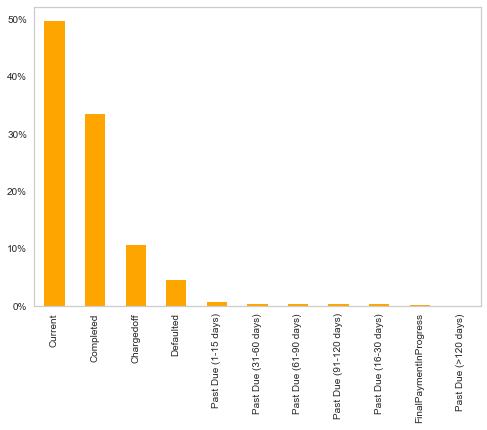

In [10]:
ax = df['LoanStatus'].value_counts(normalize=True).plot.bar(color='orange')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  
plt.grid(False)

In [11]:
df = df.drop(['LoanStatus'], axis = 1)

In [12]:
df.isnull().sum(axis = 0)
print (df.isnull().mean() * 100)
print('Columns before erasing NaN columns', (len(df.columns)))
df = df.loc[:, df.isnull().mean() <= .2]
print('Columns after erasing NaN columns', (len(df.columns)))

ListingKey                              0.000000
ListingNumber                           0.000000
ListingCreationDate                     0.000000
CreditGrade                            74.591862
Term                                    0.000000
ClosedDate                             51.651863
BorrowerAPR                             0.021943
BorrowerRate                            0.000000
LenderYield                             0.000000
EstimatedEffectiveYield                25.523119
EstimatedLoss                          25.523119
EstimatedReturn                        25.523119
ProsperRating (numeric)                25.523119
ProsperRating (Alpha)                  25.523119
ProsperScore                           25.523119
ListingCategory (numeric)               0.000000
BorrowerState                           4.837974
Occupation                              3.146614
EmploymentStatus                        1.976618
EmploymentStatusDuration                6.689078
IsBorrowerHomeowner 

In [14]:
print ('Bad Loan Ratio: %.2f%%'  % (df.rating.sum()/len(df)*100))

Bad Loan Ratio: 15.80%


In [15]:
#Clean ListeningKey,ListeningNumber and Listening Creation Date
df = df.drop(['ListingKey',], axis = 1)
df = df.drop(['ListingNumber',], axis = 1)
df = df.drop(['ListingCreationDate',], axis = 1)

In [18]:
#Clean: ProsperRating Alpha (This is already in ProsperRating Numeric)
# df = df.drop(['ProsperRating (Alpha)'], a1)

In [19]:
#Clean: Occupation
df = df.drop(['Occupation'], axis =1)

In [20]:
df['EmploymentStatus'].value_counts()
#Clean: Employment Status
#One-hot encode EmploymentStatus
one_hot = pd.get_dummies(df['EmploymentStatus'])
# Drop column Loan Originator as it is now encoded
df = df.drop('EmploymentStatus',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [21]:
#Clean Borrower Homeowner
df['IsBorrowerHomeowner'] = df['IsBorrowerHomeowner'].astype(int)
df['IsBorrowerHomeowner'].head()

0    1
1    0
2    0
3    1
4    1
Name: IsBorrowerHomeowner, dtype: int64

In [22]:
#Clean Borrower Homeowner
df['CurrentlyInGroup'] = df['CurrentlyInGroup'].astype(int)
df['CurrentlyInGroup'].head()

0    1
1    0
2    1
3    0
4    0
Name: CurrentlyInGroup, dtype: int64

In [23]:
#Clean Date Credit Pulled
df["DateCreditPulled"] = pd.to_datetime(df["DateCreditPulled"])
df['DateCreditPulled'] = df['DateCreditPulled'].dt.year
df['DateCreditPulled'].sort_values()
df['DateCreditPulled'].value_counts().sort_index()
year_dict = {2005: 0, 2006: 1, 2007: 2,2008:3, 2009: 4, 2010:5, 2011:6, 2012:7, 2013:8, 2014:9}
df['DateCreditPulled'] = df['DateCreditPulled'].map(year_dict)
df.DateCreditPulled
# df['DateCreditPulled'].head()

0         2
1         9
2         2
3         7
4         8
5         8
6         8
7         8
8         8
9         8
10        7
11        2
12        8
13        8
14        8
15        7
16        8
17        1
18        8
19        8
20        8
21        2
22        8
23        8
24        8
25        8
26        8
27        5
28        8
29        8
30        7
31        7
32        9
33        5
34        9
35        6
36        8
37        8
38        8
39        1
40        9
41        7
42        2
43        8
44        8
45        8
46        3
47        8
48        8
49        8
50        8
51        6
52        8
53        8
54        7
55        8
56        8
57        6
58        8
59        2
60        8
61        8
62        2
63        1
64        8
65        9
66        2
67        6
68        2
69        9
70        8
71        7
72        6
73        8
74        6
75        8
76        1
77        6
78        3
79        8
80        9
81        7
82        8
83  

In [27]:
#Clean: Income Range
income_dict = {'$0': 1, '$1-24,999' : 2, '$25,000-49,999'  : 3, '$50,000-74,999': 4, '$75,000-99,999' : 5, '$100,000+': 6,'Not employed':0, 'Not displayed' :np.nan}
df['IncomeRange'] = df['IncomeRange'].map(income_dict)
df['IncomeRange']

0         3.0
1         4.0
2         NaN
3         3.0
4         6.0
5         6.0
6         3.0
7         3.0
8         3.0
9         3.0
10        5.0
11        2.0
12        3.0
13        4.0
14        6.0
15        4.0
16        5.0
17        NaN
18        5.0
19        3.0
20        4.0
21        3.0
22        2.0
23        3.0
24        3.0
25        5.0
26        3.0
27        5.0
28        3.0
29        6.0
30        3.0
31        3.0
32        5.0
33        6.0
34        3.0
35        3.0
36        6.0
37        3.0
38        4.0
39        NaN
40        6.0
41        6.0
42        NaN
43        4.0
44        6.0
45        6.0
46        3.0
47        4.0
48        6.0
49        5.0
50        5.0
51        4.0
52        5.0
53        3.0
54        6.0
55        3.0
56        4.0
57        6.0
58        4.0
59        3.0
60        5.0
61        5.0
62        4.0
63        NaN
64        3.0
65        4.0
66        0.0
67        4.0
68        3.0
69        3.0
70        4.0
71    

In [28]:
#Clean: IncomeVerifiable
df = df.drop(['IncomeVerifiable'], axis=1)

In [29]:
#Clean: Loan Key
df = df.drop(['LoanKey'], axis=1)

In [30]:
#Clean: Loan Origination Date
df["LoanOriginationDate"] = pd.to_datetime(df["LoanOriginationDate"])
df['LoanOriginationDate'] = df['LoanOriginationDate'].dt.year
df['LoanOriginationDate'].sort_values()
df['LoanOriginationDate'].value_counts().sort_index()
year_dict = {2005: 0, 2006: 1, 2007: 2,2008:3, 2009: 4, 2010:5, 2011:6, 2012:7, 2013:8, 2014:9}
df['LoanOriginationDate'] = df['LoanOriginationDate'].map(year_dict)
df.DateCreditPulled.head()

0    2
1    9
2    2
3    7
4    8
Name: DateCreditPulled, dtype: int64

In [31]:
#Clean: Loan Origination Quarted
df = df.drop(['LoanOriginationQuarter'], axis =1)

In [32]:
#Clean: Member Key
df = df.drop(['MemberKey'], axis =1)

In [33]:
#Clean: First Recorded Credit Line
df = df.drop('FirstRecordedCreditLine', axis = 1)

In [35]:
#Create subsets for transfering
df_cali = df.loc[df['BorrowerState'] == 'CA']
df_de = df.loc[df['BorrowerState'] == 'CT']

In [36]:
#Drop address state column
df_cali = df_cali.drop(['BorrowerState',], axis = 1)
df_de = df_de.drop(['BorrowerState'], axis =1)

In [37]:
#Split data into X and Y
X = df_cali.loc[:, df_cali.columns != 'rating']
Y = df_cali['rating']

In [38]:
#Train model
seed = 424242
test_size = 0.2
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [39]:
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model)

[13:01:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [40]:
#Split data into X and Y for NYC
X1 = df_de.loc[:, df_de.columns != 'rating']
Y1 = df_de['rating']

In [41]:
feature_list = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending=False)
print(feature_list)

LoanCurrentDaysDelinquent             0.994744
LP_GrossPrincipalLoss                 0.001641
LoanNumber                            0.001109
InquiriesLast6Months                  0.001068
TotalInquiries                        0.001060
EmploymentStatusDuration              0.000301
RevolvingCreditBalance                0.000078
LP_ServiceFees                        0.000000
LP_NetPrincipalLoss                   0.000000
LP_CollectionFees                     0.000000
Term                                  0.000000
LP_InterestandFees                    0.000000
LP_CustomerPayments                   0.000000
MonthlyLoanPayment                    0.000000
LoanOriginationDate                   0.000000
LoanOriginalAmount                    0.000000
LP_CustomerPrincipalPayments          0.000000
LP_NonPrincipalRecoverypayments       0.000000
PercentFunded                         0.000000
Recommendations                       0.000000
InvestmentFromFriendsCount            0.000000
InvestmentFro

In [42]:
for i in range(26):
    
    seed = 424242
    test_size = 0.33
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    model = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    
    #Train TransferBoost model
    seed = 424242
    test_size = 0.33
    X_train_t, X_test_t, y_train_t, y_test_t = model_selection.train_test_split(X1, Y1, test_size=test_size, random_state=seed)
 
    
    t_xgb_model = XGBTransferLearner(model)

    t_xgb_model.fit(X_train_t,y_train_t)

    y_pred_t = t_xgb_model.predict_proba(X_test_t)
    y_pred_t = [i[1] for i in y_pred_t ]

    model_standalone = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    
    model_standalone.fit(X_train_t, y_train_t)

    y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
    #AUC SCORES XGBoost
    
    auc_inputmodel = roc_auc_score(y_test, y_pred)
    #Score with transferlearning
    auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

    #Score without transferlearning
    auc_standalone = roc_auc_score(y_test_t, y_pred_st )

    print("AUC transferboost = ",i, " feature, named", feature_list.index[i], "deleted"  , auc_transferboost)
    print("AUC standalone = ", i , " feature, named", feature_list.index[i], "deleted"  , auc_standalone)
    
    X = X.drop([feature_list.index[i]], axis = 1)
    X1 = X1.drop([feature_list.index[i]], axis = 1)

# df_columns = pd.DataFrame(X.columns)
# df_columns.to_csv('/Users/marnixtimmermans/Desktop/Thesis1/FeatureListProspergood.csv', index = False)


[13:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC transferboost =  0  feature, named LoanCurrentDaysDelinquent deleted 1.0
AUC standalone =  0  feature, named LoanCurrentDaysDelinquent deleted 0.7686036960985627
[13:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the ol

[13:02:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN: [ 151  155  164 ... 1624 1625 1626] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 152 153 154 156 157 158 159 160 161 162 163
 165]
[13:02

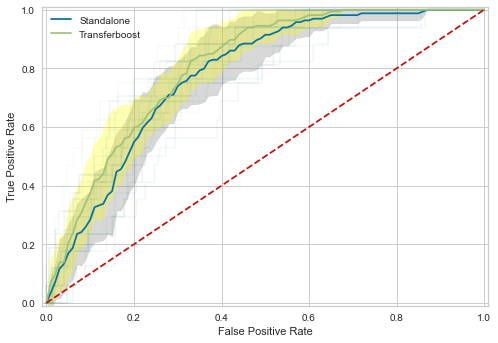

In [43]:
#Train TransferBoost model
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, Y)
skf.get_n_splits(X1, Y1)
list_of_auc_TB = []
list_of_auc_standalone = [] 
list_of_auc_initialmodel = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
tr_tprs = []
tr_base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in skf.split(X1, Y1):
    
    seed = 424242
    test_size = 0.33
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    model = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]


    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_t, X_test_t = X1.iloc[train_index], X1.iloc[test_index]
    y_train_t, y_test_t = Y1.iloc[train_index], Y1.iloc[test_index]
    
 
    t_xgb_model = XGBTransferLearner(model)

    t_xgb_model.fit(X_train_t,y_train_t)

    y_pred_t = t_xgb_model.predict_proba(X_test_t)
    y_pred_t = [i[1] for i in y_pred_t ]

    model_standalone = xgboost.XGBClassifier(**{
        'learning_rate': 0.075,
        'max_depth': 5,
        'min_child_weight': 30,
        'n_estimators': 130,
        'reg_lambda': 100,
        'scale_pos_weight': 1,
        'subsample': 0.5})
    
    model_standalone.fit(X_train_t, y_train_t)
    
    y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
    #AUC SCORES XGBoost
    #Score with initial model
    auc_inputmodel = roc_auc_score(y_test, y_pred)

    #Score with transferlearning
    auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

    #Score without transferlearning
    auc_standalone = roc_auc_score(y_test_t, y_pred_st)
    
    print("AUC Initial Model = ", auc_inputmodel)
    list_of_auc_initialmodel.append(auc_inputmodel) 
    print("AUC transferboost = ", auc_transferboost)
    list_of_auc_TB.append(auc_transferboost)
    print("AUC standalone = ", auc_standalone)
    list_of_auc_standalone.append(auc_standalone)
    
    fpr, tpr, _ = roc_curve(y_test_t, y_pred_st)
    tr_fpr, tr_tpr, _ = roc_curve(y_test_t, y_pred_t)
    
    plt.plot(fpr, tpr, 'b', alpha=0.05)
    plt.plot(tr_fpr, tr_tpr, 'g', alpha=0.05)
    
    tpr = interp(base_fpr, fpr, tpr)
    tr_tpr = interp(tr_base_fpr, tr_fpr, tr_tpr)
    
    tpr[0] = 0.0
    tr_tpr[0] = 0.0
    
    tr_tprs.append(tr_tpr)
    tprs.append(tpr)
    
    
print("Mean AUC Initial:", sum(list_of_auc_initialmodel) / len(list_of_auc_initialmodel), "Std Dev TB:", statistics.stdev(list_of_auc_initialmodel))         
print("Mean AUC TB:", sum(list_of_auc_TB) / len(list_of_auc_TB), "Std Dev TB:", statistics.stdev(list_of_auc_TB))
print("Mean AUC Standalone:", sum(list_of_auc_standalone) / len(list_of_auc_standalone), "Std Dev Standalone:", statistics.stdev(list_of_auc_standalone))

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

tr_tprs = np.array(tr_tprs)
mean_tr_tprs = tr_tprs.mean(axis=0)
tr_std = tr_tprs.std(axis=0)

tr_tprs_upper = np.minimum(mean_tr_tprs + tr_std, 1)
tr_tprs_lower = mean_tr_tprs - tr_std


plt.plot(base_fpr, mean_tprs, 'b', label='Standalone')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot(tr_base_fpr, mean_tr_tprs, 'g', label='Transferboost')
plt.fill_between(tr_base_fpr, tr_tprs_lower, tr_tprs_upper, color='yellow', alpha=0.3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
pyplot.legend()
# plt.axes().set_aspect('equal', 'datalim')
plt.show()

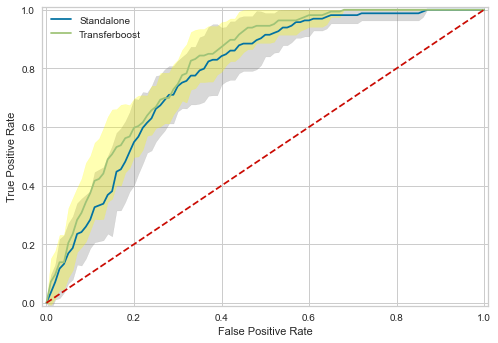

In [44]:
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

tr_tprs = np.array(tr_tprs)
mean_tr_tprs = tr_tprs.mean(axis=0)
tr_std = tr_tprs.std(axis=0)

tr_tprs_upper = np.minimum(mean_tr_tprs + tr_std, 1)
tr_tprs_lower = mean_tr_tprs - tr_std


plt.plot(base_fpr, mean_tprs, 'b', label='Standalone')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot(tr_base_fpr, mean_tr_tprs, 'g', label='Transferboost')
plt.fill_between(tr_base_fpr, tr_tprs_lower, tr_tprs_upper, color='yellow', alpha=0.3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
pyplot.legend()
# plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [45]:
import matplotlib

In [46]:
print(matplotlib.rcParams['backend'])


module://ipykernel.pylab.backend_inline


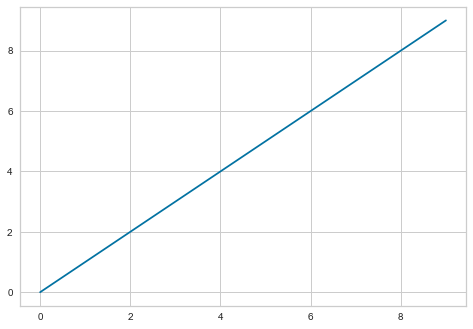

In [47]:
import matplotlib.pyplot as plt
plt.plot(range(10))
plt.show()